# Projet réduction de dimensionnalité et techniques de clustering - Projet 4

## Auteur : Nicolas Lejay

## Septembre 2023

***
## 1. Création des demi-lunes

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_moons

data, category = make_moons(n_samples=100, noise=0.1, random_state=42)
moons = pd.DataFrame(data, columns=['x', 'y'])
moons['class']=category
moons.head()

,x,y,class
0,1.582023,-0.445815,1
1,0.066045,0.439207,1
2,0.736631,-0.398963,1
3,-1.056928,0.242456,0
4,-0.802162,0.202718,0


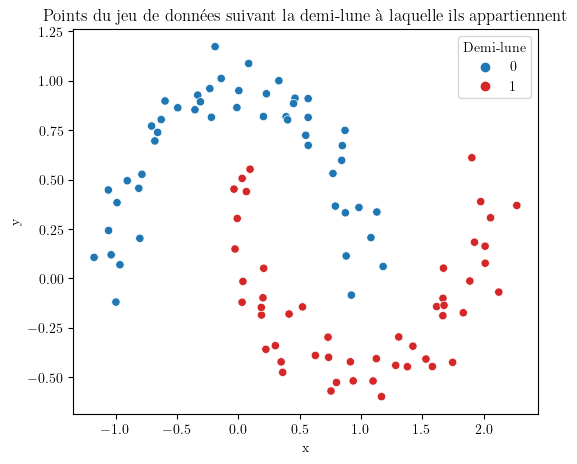

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
# Changement de police des graphiques
plt.rc('font', family = 'serif', serif = 'cmr10')
plt.rcParams.update({"text.usetex": True, "axes.formatter.use_mathtext" : True})

fig, ax = plt. subplots(figsize=(6,5))
sns.scatterplot(data=moons, x='x', y='y', hue='class', palette=["tab:blue", "tab:red"])

plt.title("Points du jeu de données suivant la demi-lune à laquelle ils appartiennent")
plt.legend(title="Demi-lune")
plt.show()

## 2. Clustering

### 2.1. Kmeans

Nous savons ici qu'il y a deux groupes de données. Nous pouvons donc demander à l'algorithme KMeans de former deux clusters.

In [3]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, n_init=50)
kmeans.fit(moons[['x','y']])

moons['cluster_kmeans'] = kmeans.labels_
moons.head()

,x,y,class,cluster_kmeans
0,1.582023,-0.445815,1,0
1,0.066045,0.439207,1,1
2,0.736631,-0.398963,1,0
3,-1.056928,0.242456,0,1
4,-0.802162,0.202718,0,1


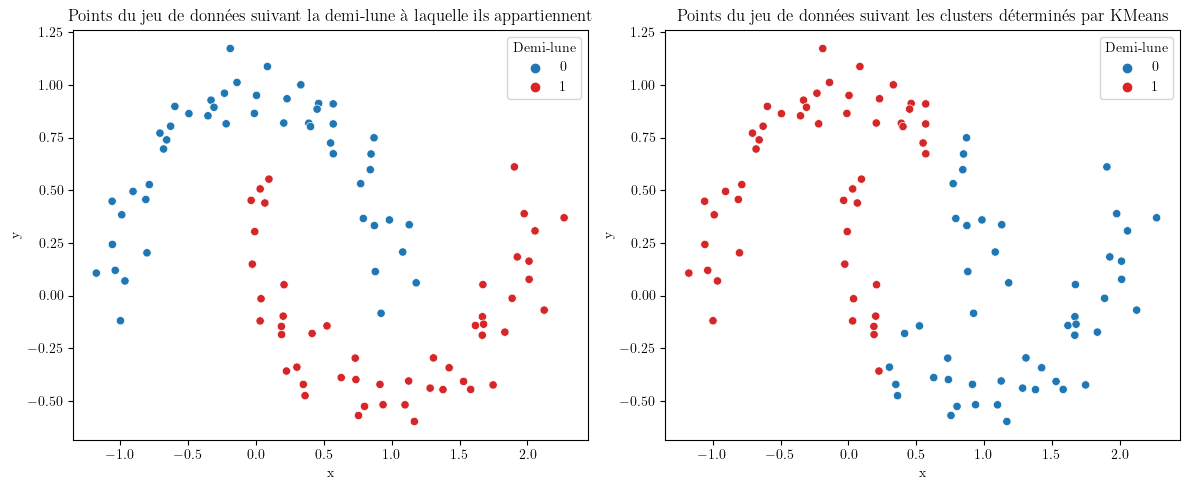

In [4]:
fig, (ax1, ax2) = plt. subplots(1,2,figsize=(12,5))

# Groupement par demi-lune
sns.scatterplot(data=moons, x='x', y='y', hue='class', palette=["tab:blue", "tab:red"], ax=ax1)
ax1.set_title("Points du jeu de données suivant la demi-lune à laquelle ils appartiennent")
ax1.legend(title="Demi-lune")

# Clusters du KMeans
sns.scatterplot(data=moons, x='x', y='y', hue='cluster_kmeans', palette=["tab:blue", "tab:red"], ax=ax2)
ax2.set_title("Points du jeu de données suivant les clusters déterminés par KMeans")
ax2.legend(title="Demi-lune")

plt.tight_layout()
plt.show()

Comme on pouvait s'y attendre, on remarque que l'algorithme KMeans n'a pas créé des clusters correspondant aux demi-lunes. Il a en effet tendance à créer des clusters de forme sphérique.

### 2.2 Classification Ascendante Hiérarchique

In [5]:
from scipy.cluster.hierarchy import linkage, dendrogram

mergings = linkage(moons[['x','y']], method='complete')

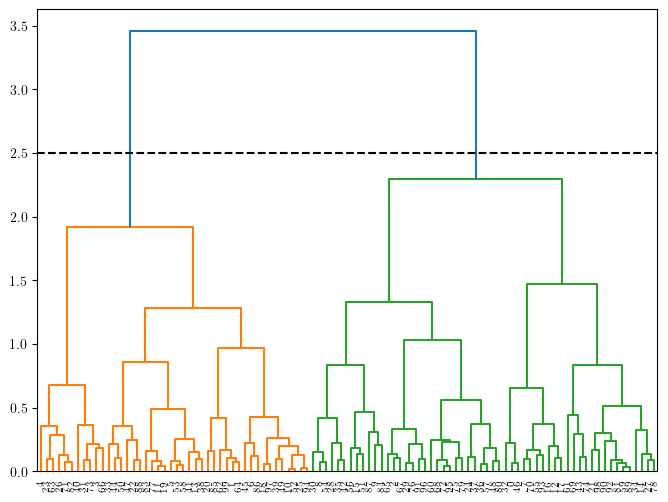

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
dendrogram(mergings, labels=[i for i in range(len(data))] , leaf_font_size=7)
plt.axhline(2.5, color='black', linestyle='--')
plt.show()

Pour constituer deux clusters, on peut opérer la coupe à une hauteur égale à 2.5.

In [7]:
from scipy.cluster.hierarchy import fcluster

clusters_cah = fcluster(mergings, t=2.5, criterion='distance')
moons['cluster_cah'] = clusters_cah
moons.head()

,x,y,class,cluster_kmeans,cluster_cah
0,1.582023,-0.445815,1,0,2
1,0.066045,0.439207,1,1,1
2,0.736631,-0.398963,1,0,2
3,-1.056928,0.242456,0,1,1
4,-0.802162,0.202718,0,1,1


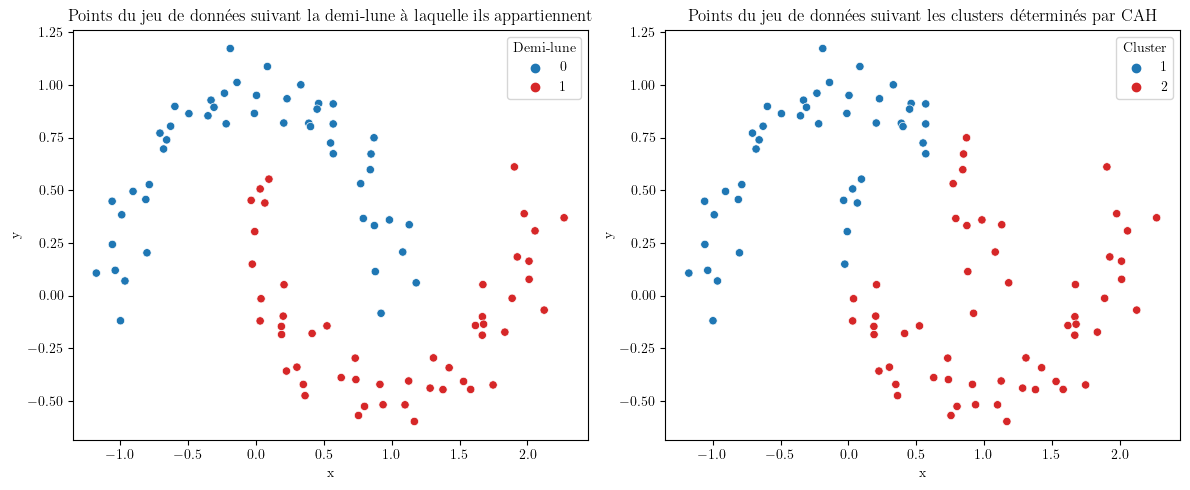

In [8]:
fig, (ax1, ax2) = plt. subplots(1,2,figsize=(12,5))

# Groupement par demi-lune
sns.scatterplot(data=moons, x='x', y='y', hue='class', palette=["tab:blue", "tab:red"], ax=ax1)
ax1.set_title("Points du jeu de données suivant la demi-lune à laquelle ils appartiennent")
ax1.legend(title="Demi-lune")

# Clusters de la CAH
sns.scatterplot(data=moons, x='x', y='y', hue='cluster_cah', palette=["tab:blue", "tab:red"], ax=ax2)
ax2.set_title("Points du jeu de données suivant les clusters déterminés par CAH")
ax2.legend(title="Cluster")

plt.tight_layout()
plt.show()

Les clusters déterminés par CAH ne correspondent pas non plus aux demi-lunes. Cette méthode forme également des clusters de forme sphérique.

### 2.3 DBSCAN

L'algorithme DBSCAN est capable de créer des clusters non sphériques. Il se base sur la densité des points. 

Voici les principales étapes de l'algorithme DBSCAN :

- Définition des voisins : pour chaque point de l'ensemble de données, les points qui sont à une distance inférieure ou égale à une certaine valeur eps fixée sont considérés comme voisins.

- Identification des points centraux (core point): un point est considéré comme un point central si dans son voisinage de rayon $\epsilon$, il y a au moins un certain nombre min_samples de points.

- Identification des points frontières (border points) : un point qui a moins de min_samples points dans son voisinage de rayon $\epsilon$, mais qui est à une distance inférieure ou égale à eps d'un point central, est un point frontière.

- Identification des points de bruit (noise points) : Un point qui n'est ni un core point, ni un border point, est un noise point.

- Regroupement: Les points centraux sont reliés s'ils sont à une distance inférieure ou égale à $\epsilon$ l'un de l'autre. Cela crée les clusters. Chaque point qui n'est pas un point central, ni un voisin d'un point central, est considéré comme un point de bruit. Si un point est un point frontière pour deux clusters, ces deux clusters sont fusionnés en un seul.

- Assignation des points: Chaque point est assigné au cluster de son point central le plus proche, ou bien est considéré comme un point de bruit.


Pour utiliser le DBSCAN, il faut régler le rayon de voisinnage $\epsilon$ d'un point de données, ce qui est assez délicat. Il faut aussi déterminer la valeur min_samples. Ici, prenons min_samples = 4 et cherchons une valeur correct de $\epsilon$. Pour cela, procédons par itérations successives. En regardant les points de données, on s'aperçoit que dans un rayon d'environ 0.25, on trouve toujours 4 points d'une même demi-lune et que ce rayon semble être trop petit pour inclure des points de l'autre demi-lune. Pour prendre de la marge, je choisis d'étudier toutes les valeurs de $\epsilon$ comprises entre 0.2 et 0.39 avec un incrément de 0.01, soit 20 valeurs. 

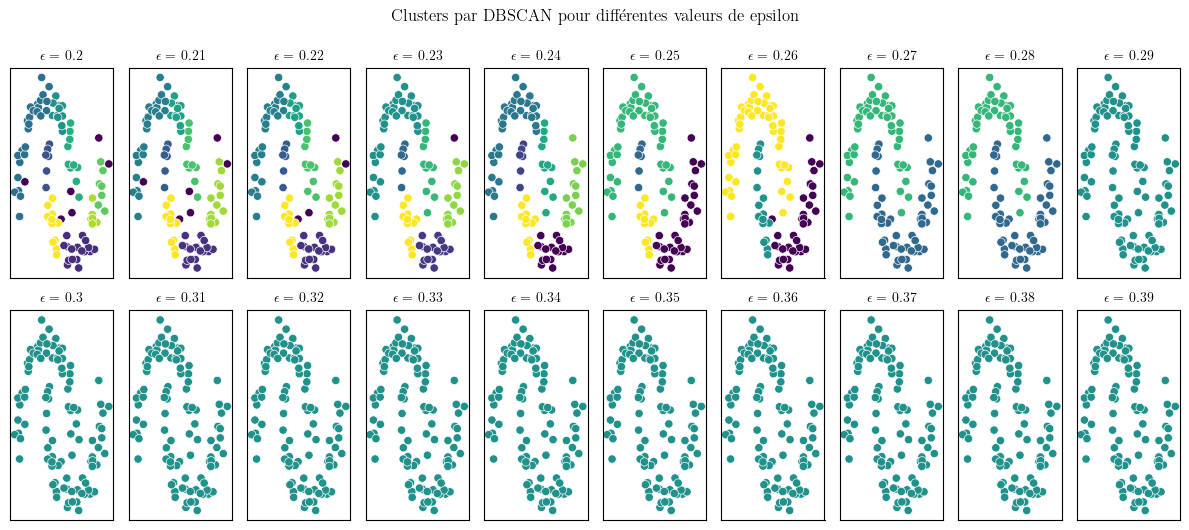

In [15]:
from sklearn.cluster import DBSCAN

fig, ax = plt. subplots(2,10,figsize=(12,5))

liste_eps = np.arange(0.2,0.4,0.01)

for num, eps in enumerate(liste_eps):
    clusters = DBSCAN(eps = eps, min_samples = 4).fit(moons[['x','y']])
    moons['cluster_dbscan'] = clusters.labels_
    
    # Clusters du DBSCAN
    i=num%10
    j=num//10
    sns.scatterplot(data=moons, x='x', y='y', hue='cluster_dbscan', palette="viridis", ax=ax[j,i], legend=False)
    ax[j,i].set_title(f"$\\epsilon=$ {round(eps,2)}", size=10)
    
    # On retire les labels et les graduations des axes pour ne pas surcharger la figure
    ax[j,i].set_xlabel('')
    ax[j,i].set_ylabel('')
    ax[j,i].set_xticks([],[])
    ax[j,i].set_yticks([],[])


plt.tight_layout()
plt.suptitle("Clusters par DBSCAN pour différentes valeurs de epsilon", y=1.05)
plt.show()

Pour un nombre minimal de points intra-voisinage égal à 4 (paramètre min_samples), les deux seules valeurs de $\epsilon$ permettant de retrouver les deux demi-lunes comme clusters sont 0.27 et 0.28.

Refaisons une figure en retenant la valeur $\epsilon=0.28$.

In [17]:
clusters = DBSCAN(eps = 0.28, min_samples = 4).fit(moons[['x','y']])

In [18]:
moons['cluster_dbscan'] = clusters.labels_
moons.head()

,x,y,class,cluster_kmeans,cluster_cah,cluster_dbscan
0,1.582023,-0.445815,1,0,2,0
1,0.066045,0.439207,1,1,1,0
2,0.736631,-0.398963,1,0,2,0
3,-1.056928,0.242456,0,1,1,1
4,-0.802162,0.202718,0,1,1,1


In [19]:
moons['cluster_dbscan'].unique()

array([0, 1])

Il n'y a pas de point de bruit (qui aurait -1 pour numéro de cluster).

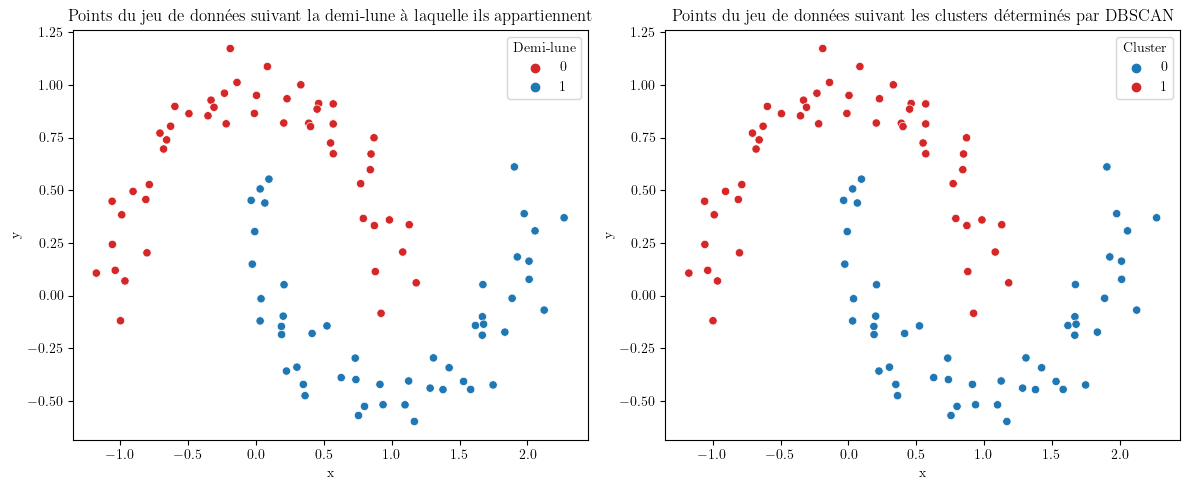

In [12]:
fig, (ax1, ax2) = plt. subplots(1,2,figsize=(12,5))

# Groupement par demi-lune
sns.scatterplot(data=moons, x='x', y='y', hue='class', palette=["tab:red", "tab:blue"], ax=ax1)
ax1.set_title("Points du jeu de données suivant la demi-lune à laquelle ils appartiennent")
ax1.legend(title="Demi-lune")

# Clusters du DBSCAN
sns.scatterplot(data=moons, x='x', y='y', hue='cluster_dbscan', palette=["tab:blue", "tab:red"], ax=ax2)
ax2.set_title("Points du jeu de données suivant les clusters déterminés par DBSCAN")
ax2.legend(title="Cluster")

plt.tight_layout()
plt.show()